(mcmc-bayes-inference-notebook)=
# Inferenza bayesiana con MCMC

In questo capitolo utilizzeremo PyMC, un pacchetto Python per la modellazione statistica bayesiana. Rispetto al capitolo precedente, in cui abbiamo utilizzato le funzioni di scipy.stats, in questo caso useremo i linguaggi di programmazione probabilistici (PPL) per scrivere il nostro campionatore. I PPL consentono di definire i modelli bayesiani utilizzando il codice del PPL e di eseguire l'inferenza bayesiana in modo abbastanza automatizzato, permettendo agli utenti di concentrarsi sulla costruzione dei modelli e meno sui dettagli matematici e computazionali.

L'algoritmo Metropolis, che abbiamo visto precedentemente, consente di generare campioni da distribuzioni di probabilità creando una catena di Markov che ha come distribuzione di equilibrio (o stazionaria) la distribuzione desiderata. Tuttavia, per modelli complessi, questo algoritmo risulta poco efficiente, richiedendo molto tempo per raggiungere una distribuzione stazionaria. Sono stati sviluppati algoritmi Monte Carlo a catena di Markov (MCMC) più efficienti, come il campionatore No-U-Turn (NUTS), gli algoritmi Metropolis-Hastings, Gibbs Sampler e Hamiltonian Monte Carlo, tutti implementati in vari framework per la programmazione probabilistica (PP), noti come "Universal Inference Engines". PyMC e Stan {cite}`carpenter2017stan` sono i due PPL più popolari. Con PyMC è possibile definire modelli complessi, anche con molte migliaia di parametri, utilizzando una sintassi leggibile e intuitiva. In questo capitolo utilizzeremo PyMC per eseguire l'inferenza su una o due proporzioni binomiali utilizzando il campionamento Monte Carlo a catena di Markov.

Iniziamo a caricare i pacchetti necessari.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import scipy.stats as st
from scipy.stats import beta
from scipy.constants import golden
# PyMC generates a FutureWarning we don't need to deal with yet
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
sns.set(color_codes=True)
az.style.use("arviz-darkgrid")
sns.set_theme(
    context="paper",
    palette="colorblind",
)

Un esempio pratico di utilizzo del linguaggio probabilistico PyMC consiste nell'eseguire una semplice operazione aritmetica. Iniziamo a sommare due numeri interi in Python.

In [3]:
# adding 2 integers in Python
a = 2
b = 3
c = a + b
print(c)


5


Facciamo ora la stessa cosa usando PyMC.

In [4]:
# adding 2 random variables in Pymc
with pm.Model() as example:
    a = pm.Normal("a", 2, 0.5)
    b = pm.Normal("b", 3, 0.2)
    c = pm.Deterministic("c", a + b)
    trace_1 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Il risultato che otteniamo è una distribuzione di probabilità di $c$. Dalla figura vediamo che la moda della distribuzione di $c$ è uguale al risultato atteso. 

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_11285/3226255793.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


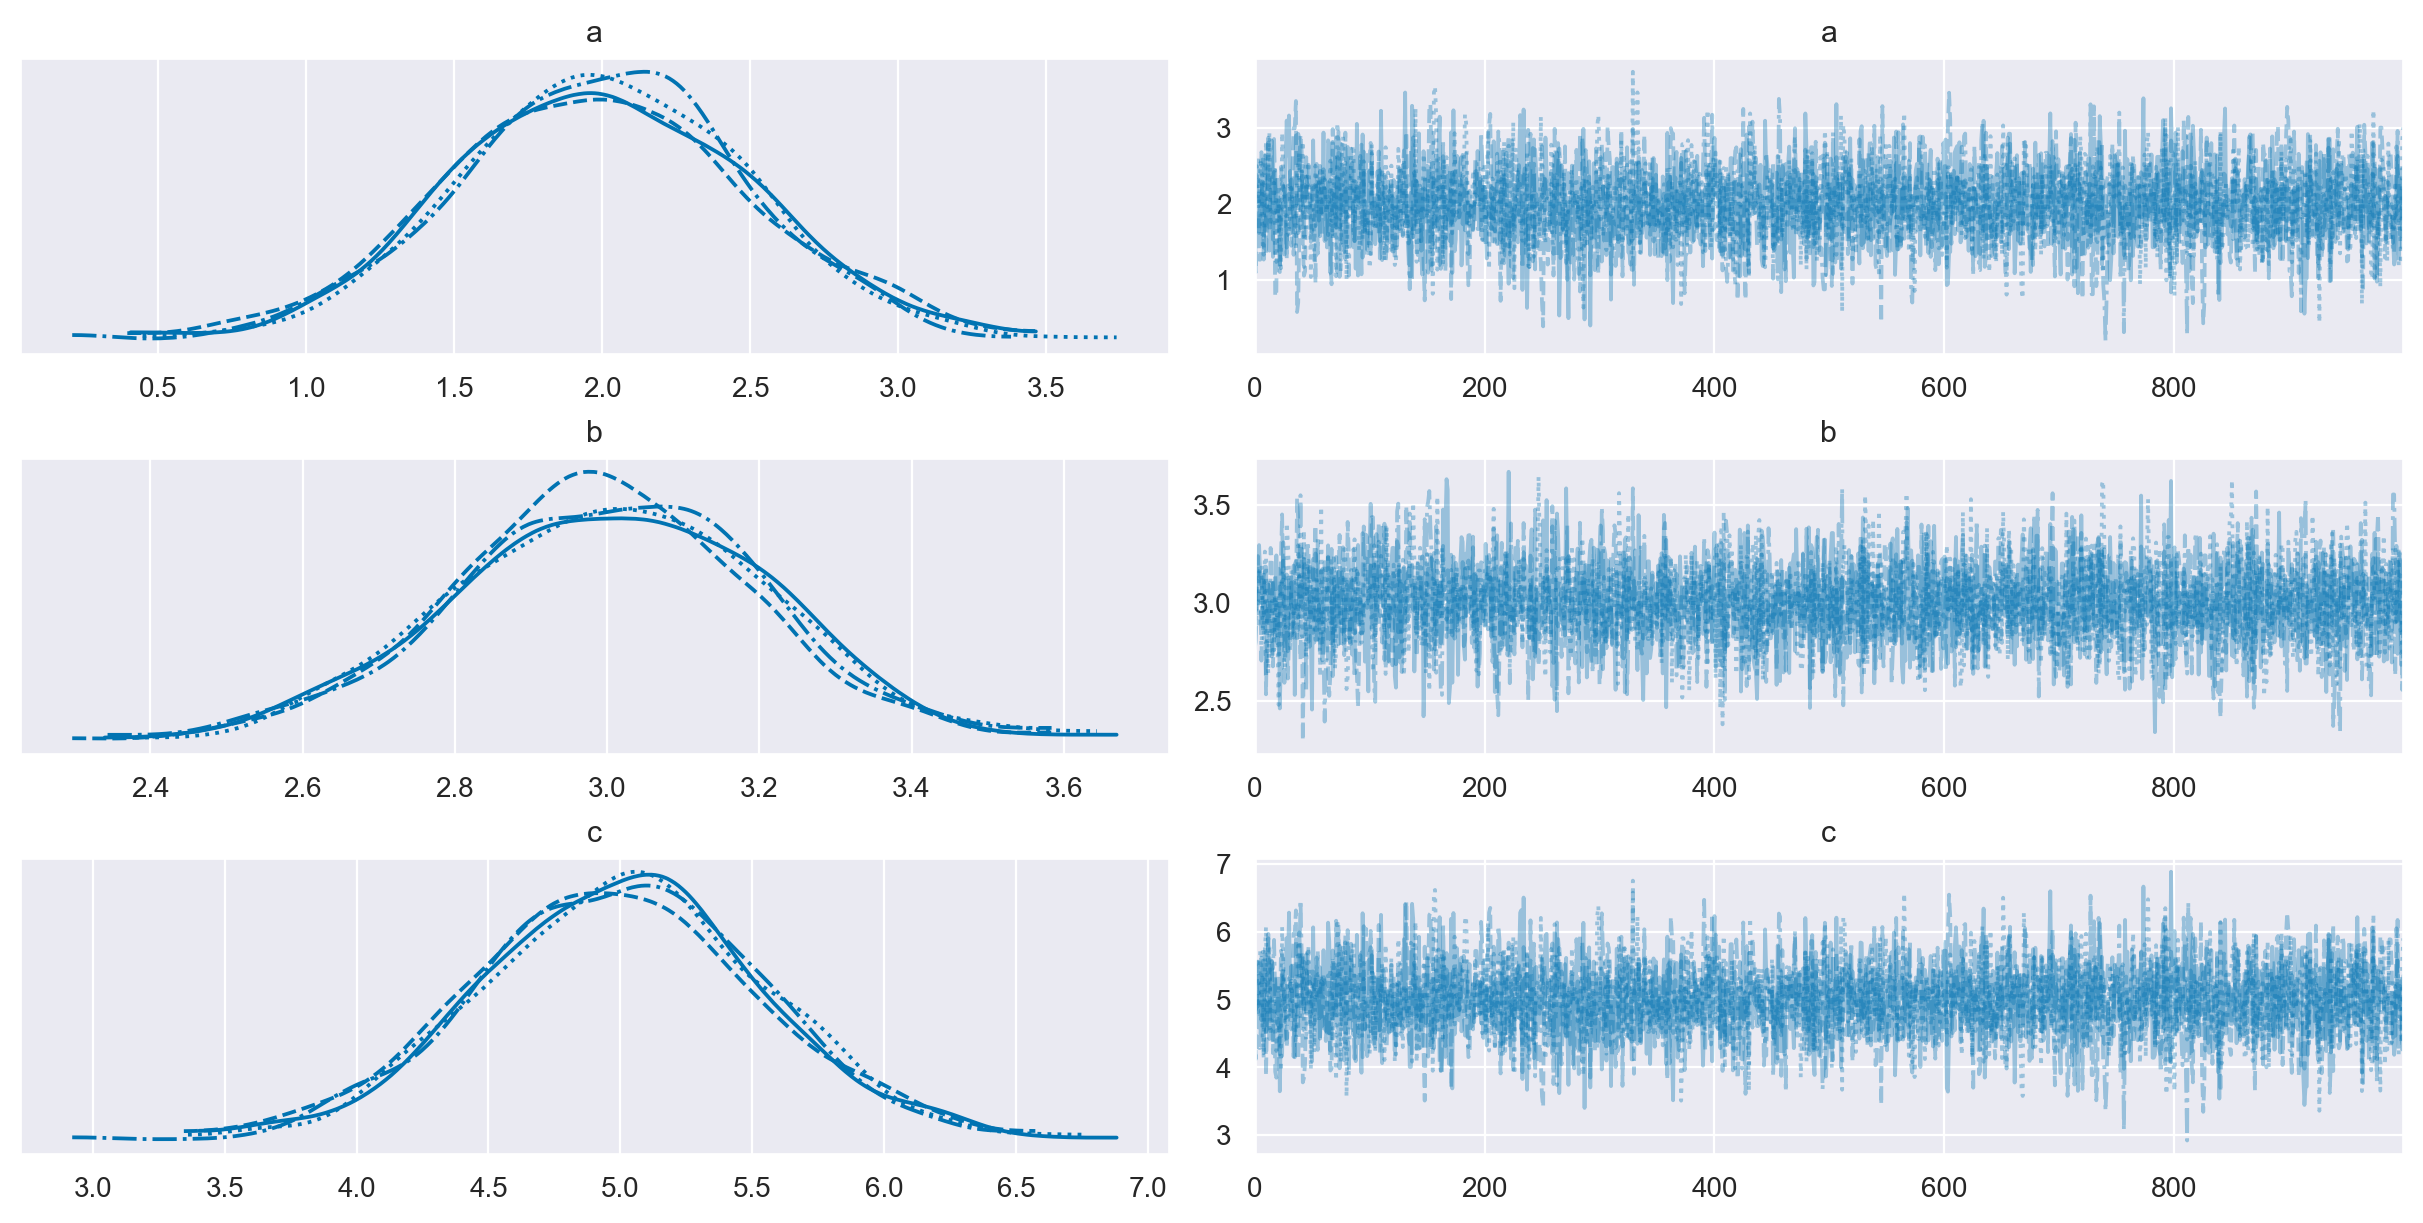

In [8]:
az.plot_trace(trace_1)
plt.tight_layout()

## Il presidente Trump e l'idrossiclorochina

Esaminiamo ora un'inferenza, non il caso di una situazione deterministica come quella vista in precedenza. Per fare un esempio concreto, considereremo un set di dati reali che può essere analizzato usando lo schema Beta-Binomiale. Cito dal *Washington Post* del 7 aprile 2020:

> One of the most bizarre and disturbing aspects of President Trump's nightly press briefings on the coronavirus pandemic is when he turns into a drug salesman. Like a cable TV pitchman hawking 'male enhancement' pills, Trump regularly extols the virtues of taking hydroxychloroquine, a drug used to treat malaria and lupus, as a potential 'game changer' that just might cure Covid-19.

Esaminiamo le evidenze a supporto dell'ipotesi che l'idrossiclorochina possa essere utile per la cura del Covid-19, ovvero le evidenze che erano disponibili nel momento in cui il Donald Trump ha fatto le affermazioni riportate sopra (in seguito, quest'idea è stata screditata). Tali evidenze sono fornite da uno studio di {cite:t}`Gautret_2020`. Il disegno sperimentale di {cite:t}`Gautret_2020` comprende, tra le altre cose, il confronto tra una condizione sperimentale e una condizione di controllo. Il confronto importante è tra la proporzione di paziente positivi al virus SARS-CoV-2 nel gruppo sperimentale (a cui è stata somministrata l'idrossiclorochina; 6 su 14) e la proporzione di paziente positivi nel gruppo di controllo (a cui non è stata somministrata l'idrossiclorochina; ovvero 14 su 16). Obiettivo di questo capitolo è mostrare come si possa fare inferenza sui dati di {cite:t}`Gautret_2020` usando PyMC. Per semplicità, iniziamo considerando solo il gruppo di controllo.

## Una proporzione

Sulla base di ciò che è stato detto nel {ref}`sec-distr-coniugate`, sappiamo che, quando i dati sono rappresentati da una proporzione $\theta$, e quando utilizziamo una distribuzione a priori Beta per $\theta$, la distribuzione a posteriori di $\theta$ è specificata dallo schema beta-binomiale. Se scegliamo, ad esempio, una $Beta(2, 2)$ quale distribuzione a priori per $\theta$, il modello diventa:

$$
\begin{align}
y &\sim Bin(n, \theta) \notag\\
\theta &\sim Beta(2, 2)
\end{align}
$$ (eq-beta-binom-trump)

dove la prima riga definisce la funzione di verosimiglianza e la seconda riga definisce la distribuzione a priori.

In questo caso specifico, è possibile ottenere una soluzione analitica in forma chiusa per stimare la distribuzione a posteriori e, quindi, non è necessario utilizzare MCMC. Nel caso di $y$ = 14 e $n$ = 16, ad esempio, otteniamo una Beta(16, 4). Esaminiamo graficamente le tre funzioni.

Text(0, 0.5, 'Densità')

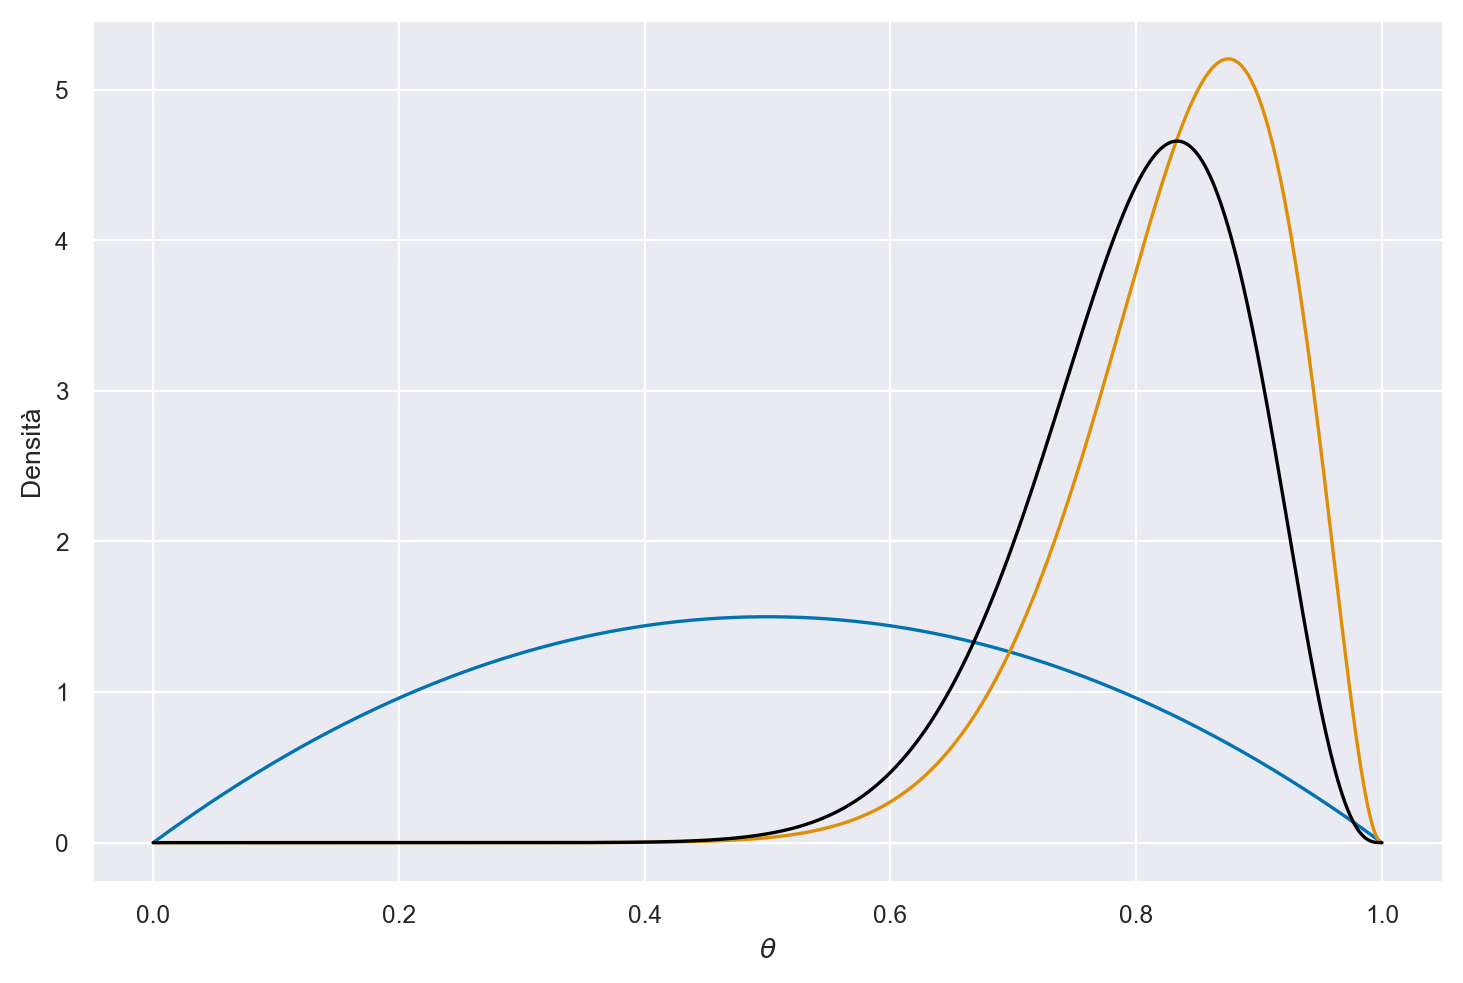

In [9]:
n_gridpoints = 1000

alpha_prior = 2
beta_prior = 2

y = 14
ntrials = 16

alpha_post = alpha_prior + y
beta_post = beta_prior + ntrials - y

theta = np.linspace(0, 1, n_gridpoints)

_, ax = plt.subplots()

# prior
fx_prior = st.beta.pdf(theta, alpha_prior, beta_prior)
_ = ax.plot(theta, fx_prior)

# likelihood
like_unstandardized = st.binom.pmf(y, ntrials, theta) 
arbitrary_constant = 18
like = like_unstandardized * arbitrary_constant
_ = ax.plot(theta, like)

# posterior
fx_post = st.beta.pdf(theta, alpha_post, beta_post)
_ = ax.plot(theta, fx_post, color="black")

ax.set_xlabel("$\\theta$")
ax.set_ylabel("Densità")

Anche se in questo caso è possibile ottenere una soluzione analitica per la distribuzione a posteriori, nella maggior parte dei modelli di inferenza bayesiana questo non è possibile, ed è pertanto necessario fare ricorso a tecniche di approssimazione numerica come MCMC. In questo esempio, applicheremo MCMC a un caso in cui conosciamo già la soluzione analitica, in modo da poter confrontare i risultati ottenuti tramite la soluzione analitica e quelli ottenuti tramite l'approssimazione numerica.

## Dedurre una proporzione con PyMC

Ora eseguiremo la stessa analisi che abbiamo svolto in precedenza utilizzando il metodo numerico Markov Chain Monte Carlo. Supponiamo di avere già installato PyMC. Una volta installato, dobbiamo successivamente importare le librerie necessarie, che includono Matplotlib, Numpy, Scipy, Arviz e lo stesso PyMC.

Vediamo ora come specificare il modello beta-binomiale mediante PyMC. Per svolgere l'analisi mediante PyMC è necessario prima specificare la struttura del modello bayesiano e poi eseguire il campionamento dalla distribuzione a posteriori. Esaminiamo questi due passaggi per l'esempio presente.

## Dati

I dati sono i seguenti e indicano che la verosimiglianza corrisponderà al modello di probabilità Binomiale. 

In [7]:
ntrials = 16
y = 14

## Distribuzione a priori

Useremo una distribuzione Beta per rappresentare tutti possibili valori della probabilità di successo, che chiameremo $\theta$. Decidiamo di rappresentare le nostre credenze a priori rispetto a $\theta$ usando una distribuzione a priori *debolmente informativa*, ovvero una distribuzione a priori che non introduce alcun bias nella stima della distribuzione a posteriori, ma si limita a escludere le possibilità estreme ($\theta$ = 0, $\theta$ = 1) assegnando alle rimanenti possibilità la maggiore incertezza possibile. Ciò può essere ottenuto scegliendo una Beta($\alpha$ = 2, $\beta$ = 2). Definiamo  i parametri della distribuzione Beta. 

In [8]:
alpha_prior = 2
beta_prior = 2

### Specificare il modello

Per specificare il modello con PyMC si usa `context with` di Python. Ciò consente di assegnare tutti i parametri, gli argomenti e i valori iniziali a un'istanza `pymc.Model` (che qui denominiamo `bb_model`).

In [9]:
bb_model = pm.Model()

with bb_model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

La prima linea di codice

`bb_model = pm.Model()`

crea un nuovo oggetto di classe `Model` che è un contenitore per le variabili casuali del modello. Dopo l'istanziazione del modello, la successiva specificazione delle componenti del modello viene eseguita all'interno di un'istruzione `with:`.

Questo crea un *context manager*, con il nostro `bb_model` come contesto, che include tutte le istruzioni fino alla fine del blocco indentato. Ciò significa che tutti gli oggetti PyMC introdotti nel blocco di codice indentato sotto l'istruzione `with:` vengono aggiunti al modello. In assenza di questo idioma del *context manager*, saremmo costretti ad associare manualmente ciascuna delle variabili a `bb_model`.

Con la chiamata del costruttore `pm.Beta` si crea una variabile casuale da usare come distribuzione a priori. Il primo argomento è sempre il nome della variabile casuale, che dovrebbe corrispondere al nome della variabile Python assegnata, poiché a volte viene utilizzato per recuperare la variabile dal modello per riassumere l'output. I restanti argomenti richiesti per un oggetto stocastico sono i parametri, in questo caso `alpha` e `beta`, a cui assegniamo i valori degli iperparametri del modello. Nel caso presente, usiamo i valori `alpha_prior` e `beta_prior` come parametri della distribuzione Beta a priori.

La riga finale del modello definisce `obs`, la distribuzione campionaria della variabile di esito nel set di dati. Questo è un caso speciale di variabile stocastica chiamata `observed stochastic`, la quale rappresenta la verosimiglianza dei dati del modello. Tale variabile stocastica è identica alle altre variabili stocastiche, tranne per l'argomento `obs`, il quale indica che i valori per questa variabile sono stati osservati e non devono essere modificati dal modello. I dati possono essere passati sotto forma di oggetto `ndarray` o `DataFrame`. Nel caso presente, per la funzione di verosimiglianza Binomiale specifichiamo il parametro `p=theta`, il numero di prove `n=ntrials` e il numero di successi `observed=y`.

Si noti che, a differenza delle distribuzioni a priori del modello, i parametri per la distribuzione Beta di `obs` non sono valori fissi, ma piuttosto corrispondono all'oggetto stocastico `theta`. Questo crea una relazione genitore-figlio tra la verosimiglianza e questa variabile.

### Campionamento

Abbiamo visto in precedenza un esempio di campionamento MCMC quando abbiamo discusso l'algoritmo di Metropolis. PyMC automatizza questa procedura. Nel caso presente, eseguiamo il campionamento MCMC usando l'algoritmo di default (NUTS) -- che è una variante dell'algoritmo di Metropolis -- e salviamo i risultati nell'oggetto `idata`.

In [10]:
with bb_model:
    step = pm.NUTS()
    idata = pm.sample(2000, tune=1000, step=step, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


La funzione `sample` esegue il metodo `step` assegnato (o passato) ad essa per il numero specificato di iterazioni (in questo caso, 2000 oltre a 1000 di burn-in) e restituisce un oggetto `InferenceData` contenente i campioni raccolti, insieme ad altri attributi utili come le statistiche dell'esecuzione del campionamento e una copia dei dati osservati. 

Si noti che `sample` genera una serie di catene parallele, a seconda del numero di *core* di calcolo presenti sulla macchina. Per la macchina che sto usando io, dove ci sono 4 cores, vengono eseguite 4 catene in parallelo. Come dice il messaggio che viene stampato da `sample`, in questo modo si ottengono 8000 campioni casuali dalla distribuzione a posteriori, dopo un burn-in iniziale di 4000 iterazioni.

```{admonition} Nota
`InferenceData` è un formato di dati specificamente progettato per le analisi bayesiane MCMC. Lo scopo principale dell'oggetto `InferenceData` è fornire un modo conveniente per archiviare e manipolare le informazioni generate durante un flusso di lavoro bayesiano, inclusi i campioni dalle distribuzioni a posteriori, la distribuzione a priori, le distribuzioni predittive a posteriori, le distribuzioni predittive a priori e altre informazioni e diagnostiche generate durante il campionamento.
```

Avendo assunto una distribuzione a priori per il parametro $\theta$, l'algoritmo procede in maniera ciclica, correggendo la distribuzione a priori di $\theta$ condizionandola ai valori già generati. Dopo un certo numero di cicli, necessari per portare l'algoritmo a convergenza, i valori estratti possono essere assunti come campionati dalla distribuzione a posteriori di $\theta$.

Al crescere del numero di passi della catena, la distribuzione di target (ovvero, la distribuzione a posteriori) viene approssimata sempre meglio. All'inizio del campionamento, però, la distribuzione può essere significativamente lontana da quella stazionaria, e ci vuole un certo tempo prima di raggiungere la distribuzione stazionaria di equilibrio, detto, appunto, periodo di *burn-in*. I campioni provenienti da tale parte iniziale della catena vanno tipicamente scartati perché possono non rappresentare accuratamente la distribuzione a posteriori.

Il tempo di campionamento dipende dalla velocità del computer a disposizione.

In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

I vari attributi dell'oggetto `InferenceData` possono essere estratti come nel caso di un `dict` contenente coppie composte da una chiave e un valore separati tra loro dal simbolo dei due punti. In questo caso le chiavi sono i nomi delle variabili e i valori sono dei `numpy.arrays`. Ad esempio, possiamo recuperare la traccia di campionamento dalla variabile latente `theta` nel modo seguente.

In [12]:
idata.posterior["theta"]

<xarray.DataArray 'theta' (chain: 4, draw: 2000)>
array([[0.88670616, 0.88531451, 0.64319942, ..., 0.86070354, 0.68997837,
        0.85222994],
       [0.81714959, 0.83852291, 0.8484301 , ..., 0.88061753, 0.92960902,
        0.94755357],
       [0.90486266, 0.89776504, 0.84923646, ..., 0.94476091, 0.87821468,
        0.81521645],
       [0.66404489, 0.75920349, 0.73890208, ..., 0.70811798, 0.80658826,
        0.8197119 ]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

Si noti che l'oggetto ritornato è un array

In [13]:
idata.posterior["theta"].shape

(4, 2000)

di dimensioni 4 $\times$ 2000 (sul mio computer). Per visualizzare il primi 10 valori della prima catena, ad esempio, usiamo:

In [14]:
idata.posterior["theta"][0, 1:10]

<xarray.DataArray 'theta' (draw: 9)>
array([0.88531451, 0.64319942, 0.71441086, 0.71803   , 0.73779223,
       0.6691467 , 0.63731638, 0.88789884, 0.65335186])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 1 2 3 4 5 6 7 8 9

Se volessimo utilizzare l'algoritmo di campionamento Metropolis invece di NUTS (che è stato assegnato di default), possiamo specificare questo come argomento `step` per `sample`.

In [15]:
with bb_model:
    # Instantiate sampler
    step = pm.Metropolis()
    # Draw 2000 posterior samples
    metropolis_idata = pm.sample(2000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


### Analisi a posteriori

Esaminiamo l'accettanza.

<Axes: title={'center': 'acceptance_rate'}>

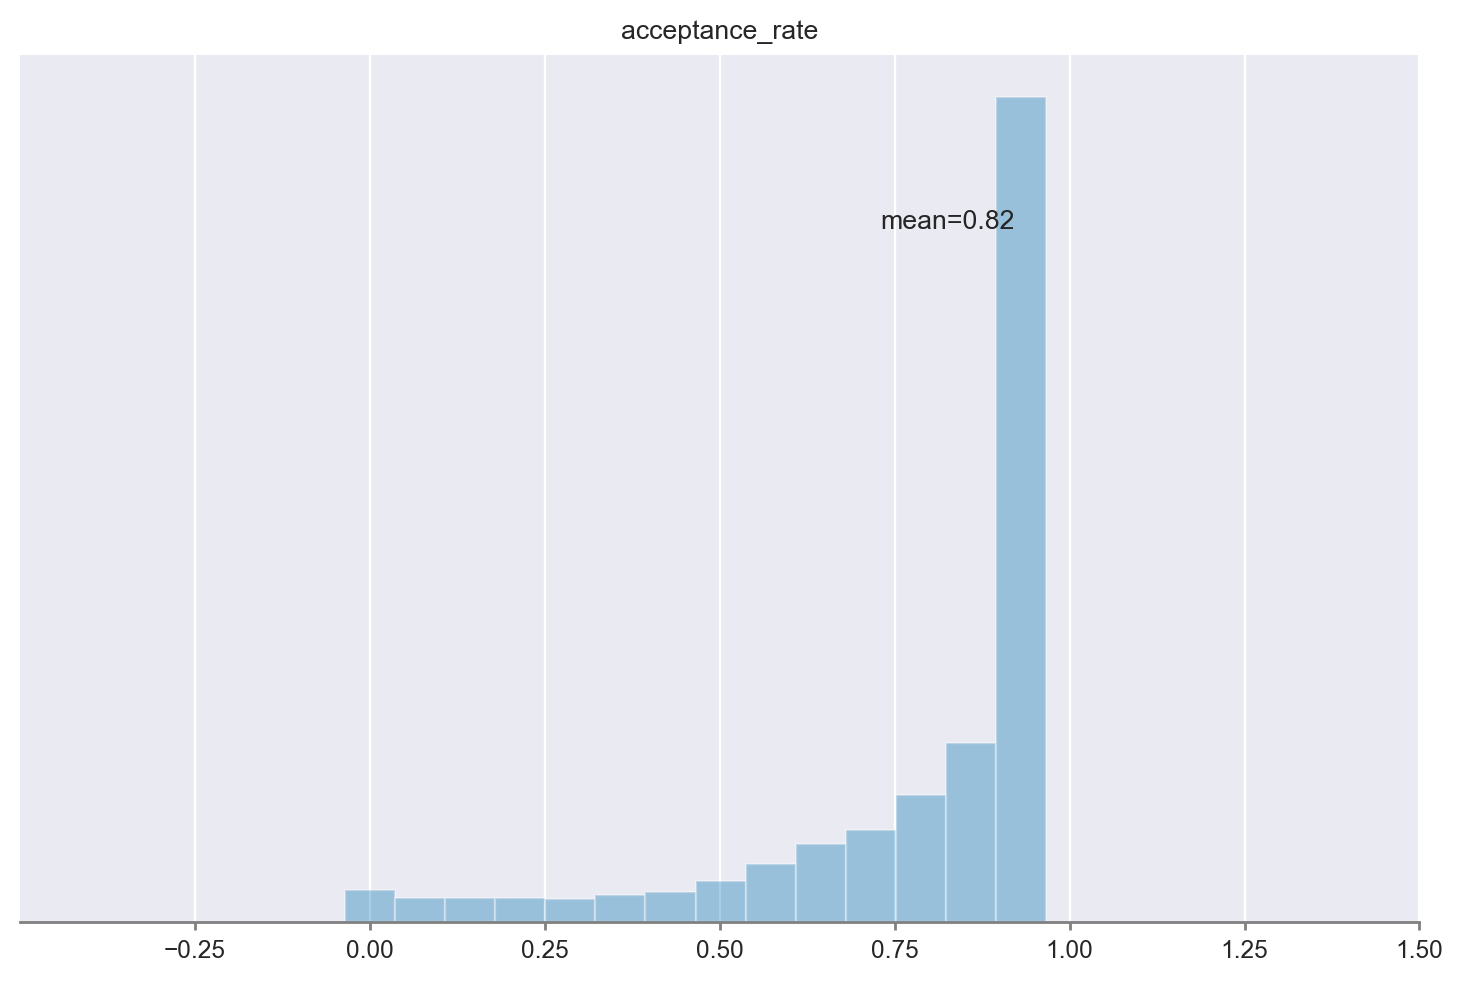

In [16]:
az.plot_posterior(
    idata,
    group="sample_stats",
    var_names="acceptance_rate",
    hdi_prob="hide",
    kind="hist",
)

Estraiamo le stime a posteriori di $\theta$ da `idata`.

In [17]:
posterior = az.extract(idata)

Le stime a posteriori di $\theta$ sono accessibili nel modo seguente.


In [18]:
posterior["theta"]

<xarray.DataArray 'theta' (sample: 8000)>
array([0.88670616, 0.88531451, 0.64319942, ..., 0.70811798, 0.80658826,
       0.8197119 ])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999

Dato che `posterior['theta']` è una lista, possiamo facilmente calcolare la media a posteriori

In [19]:
posterior["theta"].mean()

<xarray.DataArray 'theta' ()>
array(0.79924948)

oppure la mediana a posteriori di $\theta$


In [20]:
posterior["theta"].median()

<xarray.DataArray 'theta' ()>
array(0.81006368)

La deviazione standard della stima a posteriori è


In [21]:
np.std(posterior["theta"])

<xarray.DataArray 'theta' ()>
array(0.08917436)

Per semplicità, salvo le stime a posteriori di $\theta$ in un array.


In [22]:
p_post = posterior["theta"]

Possiamo ora fare inferenza usando i risultati ottenuti. Un sommario della distribuzione a posteriori si ottiene con il metodo `az.summary()`.

In [23]:
az.summary(idata, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.799,0.089,0.625,0.952,0.002,0.001,3159.837,4281.866,1.0


Si ottiene così l'intervallo di credibilità a più alta densità a posteriori (HPD) al 95%. Questo intervallo ci informa sul fatto che, a posteriori, possiamo essere certi al 95%, che il vero valore del parametro $\theta$ sia contenuto nell'intervallo \[0.625, 0.95\].

Un risultato praticamente identico si ottiene usando l'algoritmo di Metropolis, anziché NUTS.

In [24]:
az.summary(metropolis_idata, hdi_prob=0.95, round_to=3)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.798,0.088,0.623,0.954,0.002,0.001,1852.558,2059.608,1.001


L'output grafico dell'analisi è riportato nel grafico seguente.

Text(0, 0.5, 'Densità')

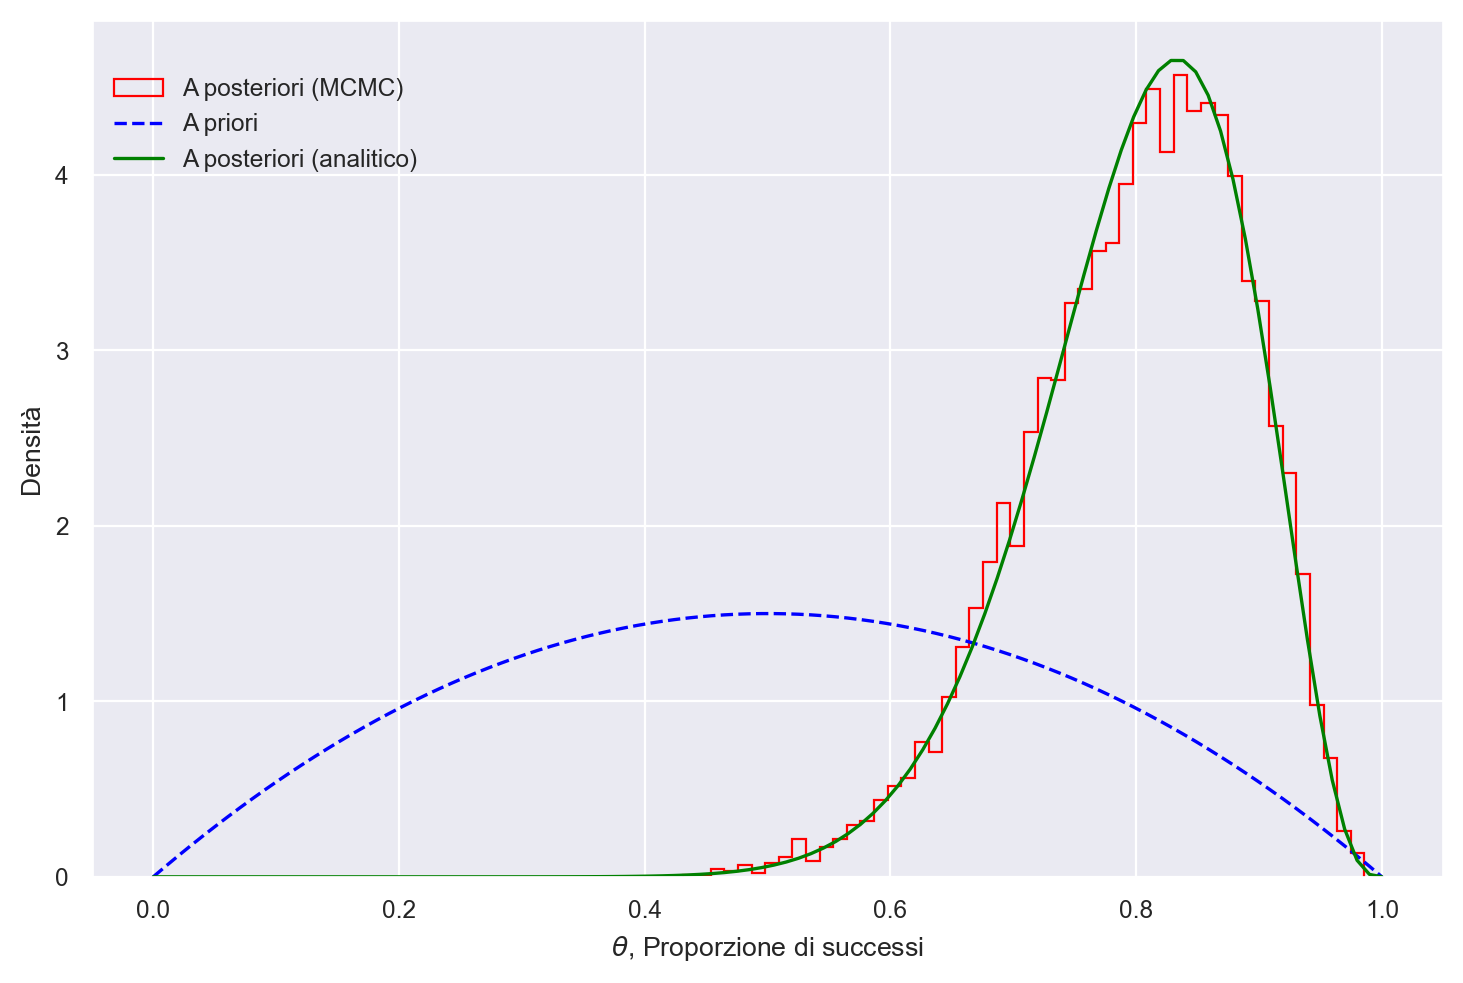

In [25]:
# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + ntrials - y

plt.hist(
    p_post,
    bins=50,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="red",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, alpha_prior, beta_prior), "--", label="A priori", color="blue")
plt.plot(
    x,
    beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="green",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità")

In questo esempio, con 8,000 campioni, la convergenza dell'algoritmo NUTS è estremamente buona. L'istogramma segue da vicino la distribuzione a posteriori calcolata analiticamente, come da previsione.

Un tracciato della catena di Markov illustra questa esplorazione rappresentando il valore $\theta$ sulle ordinate e l'indice progressivo di in ogni iterazione sull'ascissa. Il trace plot è estremamente utile per valutare la convergenza di un algoritmo MCMC e se è necessario escludere un periodo di campioni iniziali (noto come burn-in). Per produrre la traccia chiamiamo semplicemente `az.plot_trace()` con la variabile `idata`:

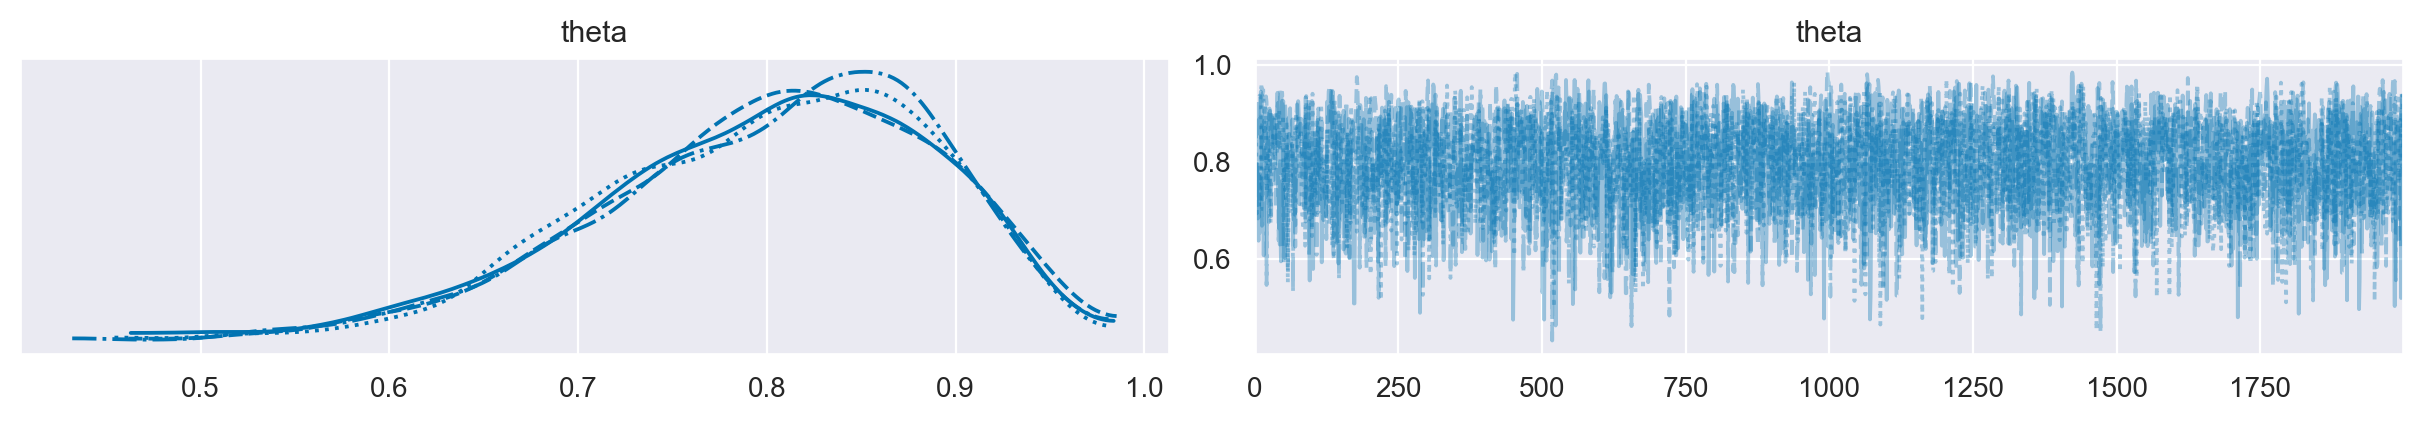

In [26]:
az.plot_trace(idata)
plt.show()

La traccia descrive il comportamento *longitudinale* delle catene di Markov. Possiamo usare il metodo `az.plot_trace()` per visualizzare sia la traccia sia una stima della densità del kernel (KDE) dell'istogramma delle stime a posteriori, ovvero, dei valori che le catene MCMC visitano lungo il loro percorso, ignorando l'ordine di queste visite. Da notare come la stima di KDE della convinzione a posteriori nella probabilità di efficacia dell'idrossiclorochina riflette sia la convinzione a priori di 𝜎=0.22 che i nostri dati con una correttezza campionaria di 𝜎=0.09. Inoltre possiamo vedere che la procedura di campionamento MCMC è "convergente alla distribuzione" poiché la serie di campionamento sembra stazionaria.

Svolgendo un'analisi bayesiana simile a questa, {cite:t}`Gautret_2020` hanno trovato che gli intervalli di credibilità del gruppo di controllo e del gruppo sperimentale non si sovrappongono. Questo fatto viene interpretato dicendo che il parametro $\theta$ è diverso nei due gruppi. Sulla base di queste evidenza, {cite:t}`Gautret_2020` hanno concluso, con un grado di certezza soggettiva del 95%, che nel gruppo sperimentale vi è una probabilità più bassa di risultare positivi al SARS-CoV-2 rispetto al gruppo di controllo. In altri termini, l'analisi statistica condotta da {cite:t}`Gautret_2020` suggerisce che l'idrossiclorochina è una terapia efficace per il Covid-19.

## La critica di Hulme (2020)

Un articolo pubblicato da {cite:t}`Hulme_2020` si è posto il problema di rianalizzare i dati di {cite:t}`Gautret_2020`.[^040_beta_binomial_mod-1] Tra gli autori di questo articolo figura anche Eric-Jan Wagenmakers, uno psicologo molto conosciuto per i suoi contributi metodologici. {cite:t}`Hulme_2020` osservano che, nelle loro analisi statistiche, {cite:t}`Gautret_2020` hanno escluso alcuni dati. Nel gruppo sperimentale, infatti, vi erano alcuni pazienti i quali, anziché migliorare, sono in realtà peggiorati. L'analisi statistica di {cite:t}`Gautret_2020` ha escluso i dati di questi pazienti. Se consideriamo tutti i pazienti -- non solo quelli selezionati da {cite:t}`Gautret_2020` -- la situazione diventa la seguente:

[^040_beta_binomial_mod-1]: Si veda <https://osf.io/5dgmx/>.

-   gruppo sperimentale: 10 positivi su 18;
-   gruppo di controllo: 14 positivi su 16.

L'analisi dei dati proposta da {cite}`Hulme_2020` richiede l'uso di alcuni strumenti statistici che, in queste dispense, non verranno discussi. Ma possiamo giungere alle stesse conclusioni raggiunte da questi ricercatori anche usando le procedure statistiche descritte nel Paragrafo successivo.

## Due proporzioni

Svolgiamo ora l'analisi statistica considerando tutti i dati, come suggerito da {cite}`Hulme_2020`. Per fare questo verrà creato un modello bayesiano per fare inferenza sulla differenza tra due proporzioni. Dopo avere generato le distribuzioni a posteriori per le proporzioni di "successi" nei due gruppi, calcoleremo la quantità

$$
\omega = \frac{\theta_2 / (1-\theta_2)}{\theta_1 / (1-\theta_1)},
$$ (eq-odds-ratio)

ovvero il rapporto tra gli Odds di positività tra i pazienti del gruppo di controllo e gli Odds di positività tra i pazienti del gruppo sperimentale. Se il valore dell'OR è uguale a 1, significa che l'Odds di positività nel gruppo di controllo è uguale all'Odds di positività nel gruppo sperimentale, cioè il fattore in esame (somministrazione dell'idrossiclorochina) è ininfluente sulla comparsa della malattia. L'inferenza statistica sull'efficacia dell'idrossiclorochina come terapia per il Covid-19 può dunque essere effettuata esaminando l'intervallo di credibilità al 95% per l'OR: se tale intervallo include il valore 1, allora non c'è evidenza che l'idrossiclorochina sia efficace come terapia per il Covid-19.

Nell'implementazione di questo modello, la quantità di interesse è l'odds ratio; tale quantità viene calcolata nel blocco `generated quantities`. Per i parametri $\theta_1$ e $\theta_2$ useremo delle distribuzioni a priori debolmente informative il cui scopo è la regolarizzazione dei dati.

Elenchiamo i dati dei due gruppi.

In [28]:
# Define the data for proportion 1
y1 = 14
n1 = 16

# Define the data for proportion 2
y2 = 10
n2 = 18

Definiamo il modello.


In [29]:
with pm.Model() as model:
    # Define the priors for the two proportions
    p1 = pm.Beta("p1", alpha=2, beta=2)
    p2 = pm.Beta("p2", alpha=2, beta=2)

    # Define the likelihood functions for the two proportions
    likelihood1 = pm.Binomial("likelihood1", n=n1, p=p1, observed=y1)
    likelihood2 = pm.Binomial("likelihood2", n=n2, p=p2, observed=y2)

    # Define the difference of odds model
    odds_ratio = pm.Deterministic("odds_ratio", (p1 / (1 - p1)) / (p2 / (1 - p2)))


Eseguiamo il campionamento MCMC.


In [30]:
with model:
    trace = pm.sample(draws=2000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1, p2]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.


Esaminiamo i risulati.

In [31]:
az.hdi(trace, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:     (hdi: 2)
Coordinates:
  * hdi         (hdi) <U6 'lower' 'higher'
Data variables:
    p1          (hdi) float64 0.6334 0.9532
    p2          (hdi) float64 0.3458 0.7398
    odds_ratio  (hdi) float64 0.521 12.57

L'intervallo di credibilità del 95% per l'OR include il valore di 1.0 (ovvero, il valore che indica che gli Odds di positività sono uguali nei due gruppi). In base agli standard correnti, un risultato di questo tipo non viene considerato come evidenza sufficiente per potere concludere che il parametro $\theta$ assume un valore diverso nei due gruppi. In conclusione, se consideriamo tutti i dati, e non solo quelli selezionati da {cite:t}`Gautret_2020`, non vi sono evidenze sull'efficacia dell'idrossiclorochina come terapia per il Covid-19.

## Commenti e considerazioni finali 

La ricerca di {cite:t}`Gautret_2020` include altre informazioni e altre analisi statistiche che non sono state qui considerate. Tuttavia, la semplice analisi statistica che abbiamo qui descritto è stata in grado di replicare le conclusioni a cui sono giunti (per altra via) {cite:t}`Hulme_2020`.

## Watermark

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

pandas    : 1.5.3
scipy     : 1.10.1
numpy     : 1.23.5
seaborn   : 0.12.2
pymc      : 5.3.0
matplotlib: 3.7.1
arviz     : 0.15.1

Watermark: 2.3.1

